In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy, pickle
import matplotlib

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_wc
from neurolib.optimal_control import cost_functions as cost_functions
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_singlenode
import scipy

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

# We define colors for later convenience
color_x = 'red'
color_y = 'blue'
fs_=16
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.titlesize"] = fs_
plt.rcParams["axes.labelsize"] = fs_
matplotlib.rc('xtick', labelsize=fs_) 
matplotlib.rc('ytick', labelsize=fs_) 
plt.rc('legend',fontsize=fs_)

In [2]:
def plot_single(time, state, control, target, filename=None):

    fig, ax = plt.subplots(2,1)

    ax[0].plot(time, state[0,0,1:], color="red")
    ax[0].plot(time, state[0,1,1:], color="blue")
    ax[0].plot(time, target[0,0,1:], color="red", linestyle=':')
    ax[0].plot(time, target[0,1,1:], color="blue", linestyle=':')
    #ax[0].set_xlim(0,300)

    ax[1].plot(time, control[0,0,1:], color="red")
    ax[1].plot(time, control[0,1,1:], color="blue")
    #ax[1].set_xlim(0,300)

    if type(filename) != type(None):
        plt.savefig(filename)
    plt.show()

savepath =  '..' + os.sep + '..' + os.sep + '..' + os.sep + '..' + os.sep + 'writing' + os.sep + 'paper2_chaos' + os.sep + 'exploration' + os.sep + 'images_ops' + os.sep

def plot(c_array, filename):

    fig, ax = plt.subplots(len(c_array),1, figsize=(10,2.*len(c_array)))

    for i in range(len(c_array)):
        ax[i].plot(wc_controlled.model.t, c_array[i][0,0,1:], color="red")
        ax[i].plot(wc_controlled.model.t, c_array[i][0,1,1:], color="blue")
        ax[i].set_ylim([-0.4,0.4])
        ax[i].set_title(str(np.round(i*2./(len(c_array)-1), 2))+ " * pi")
        if i != len(c_array)-1:
            ax[i].set_xticklabels([])

    plt.savefig(os.path.join(savepath, filename))
    plt.show()

period =  18.900000000000002
peaks =  [ 109  297  485  674  863 1052 1241 1430 1619 1808 1997]
minima =  [  17  198  386  575  764  953 1142 1331 1520 1709 1898]
peaks =  [  57  245  433  622  811 1000 1189 1378 1567 1756 1945]
minima =  [  56  244  433  622  811 1000 1189 1378 1567 1756 1945]


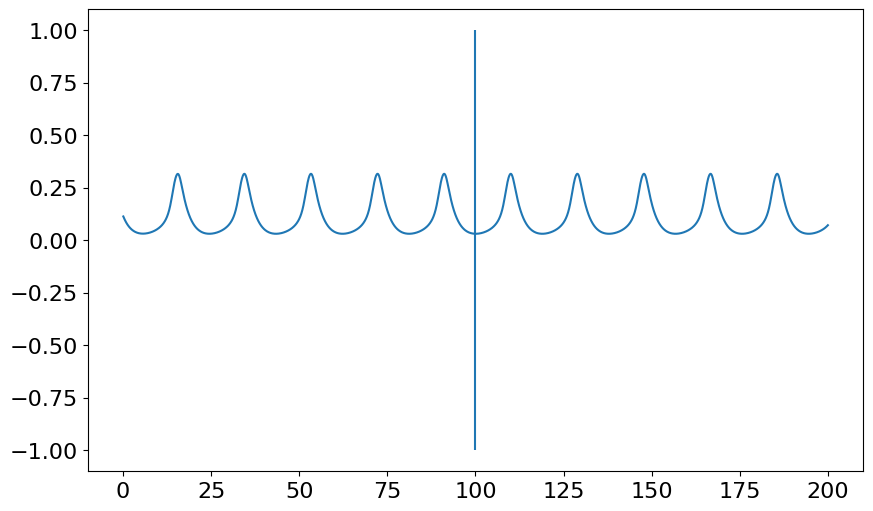

In [5]:
wc = WCModel()
wc.params.sigma_ou = 0.

dt = 0.1
wc.params.dt = dt

duration = 200.
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
zero_control =np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]
input = zero_control.copy()

wc.params["duration"] = duration
x_init = 0.045135938287846025
y_init = 0.08586538415443892
wc.params["exc_init"] = np.array([[x_init]])
wc.params["inh_init"] = np.array([[y_init]])

wc.params["exc_ext"] = zero_input + 1.
wc.params["inh_ext"] = zero_input

wc.run()

peaks = scipy.signal.find_peaks(wc.exc[0,:])[0]
period = (peaks[-1] - peaks[-2])*dt
print("period = ", period)

wc.run()
peaks = scipy.signal.find_peaks(wc.exc[0,:])[0]
print("peaks = ", peaks)
init_peak = [wc.exc[0,51], wc.inh[0,51]]

mins = scipy.signal.find_peaks(-wc.exc[0,:])[0]
print("minima = ", mins)
init_min = [wc.exc[0,141], wc.inh[0,141]]

wc.params["exc_init"] = np.array([[init_peak[0]]])
wc.params["inh_init"] = np.array([[init_peak[1]]])
wc.run()
target_peak = np.concatenate((np.concatenate( (wc.params["exc_init"], wc.params["inh_init"]), axis=1)[:,:, np.newaxis], np.stack( (wc.exc, wc.inh), axis=1)), axis=2)

peaks = scipy.signal.find_peaks(wc.exc[0,:])[0]
print("peaks = ", peaks)

wc.params["exc_init"] = np.array([[init_min[0]]])
wc.params["inh_init"] = np.array([[init_min[1]]])
wc.run()
target_min = np.concatenate((np.concatenate( (wc.params["exc_init"], wc.params["inh_init"]), axis=1)[:,:, np.newaxis], np.stack( (wc.exc, wc.inh), axis=1)), axis=2)

mins = scipy.signal.find_peaks(-wc.exc[0,:])[0]
print("minima = ", mins)

plt.plot(wc.t, wc.exc[0,:])
plt.vlines(100,-1,1)
plt.show()

In [6]:
control_mat = np.zeros( (wc.params.N, len(wc.state_vars)) )
control_mat[0,0] = 1.
control_mat[0,1] = 1.

prec_mat = np.zeros( (wc.params.N, len(wc.output_vars)) )
prec_mat[0,0] = 1.
prec_mat[0,1] = 1.

int0, int1 = 1000, None
c0, c1 = None, 1000 + np.round(period/dt).astype(int)

duration = 150.
wc.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
zero_control =np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]

wc.params["exc_ext"] = zero_input + 1.
wc.params["inh_ext"] = zero_input

In [11]:
n_points = 41
w_array = [0.125, .25, 0.5, 1., 2., 4., 8.]
none_array = [[None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points ]
file_array = ["0-125_min.png", "0-25_min.png", "0-5_min.png", "1_min.png", "2_min.png", "4_min.png", "8_min.png"]

results_min = dict([
    ('w2', w_array),
    ('models', [[None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points ]),
    ("total_cost", [[None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points ]),
    ("precision_cost", [[None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points ]),
    ("L2_cost_unweighted", [[None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points ]),
    ("L2_cost_weighted", [[None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points ]),
    ("control", [[None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points ]),
    ("state", [[None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points ]),
    ("filename", file_array)
    ])

In [31]:
wc.params["exc_init"] = np.array([[init_min[0]]])
wc.params["inh_init"] = np.array([[init_min[1]]])

for i_w in range(len(results_min["w2"])):

    if i_w not in [5]:
        continue

    w2 = results_min['w2'][i_w]

    for i_shift in range(n_points):

        break
    
        period_shift = i_shift* 2.* np.pi / (n_points-1)
        index_shift = np.round(period * period_shift/ ( 2. * np.pi)/ dt).astype(int)
        target_shift = target_peak[:,:,index_shift:index_shift+np.round(1+duration/dt,1).astype(int)]

        wc_controlled = oc_wc.OcWc(wc, target=target_shift, w_p=1, w_2=w2, print_array=np.arange(0,1001,1001), precision_cost_interval=(int0,int1), control_interval=(c0, c1), control_matrix=control_mat, precision_matrix=prec_mat)
        results_min["models"][i_w][i_shift] = wc_controlled

        wc_controlled.step = 1e-3
        wc_controlled.optimize(100)

        if i_shift in [0, n_points-1]:
            state = wc_controlled.get_xs()
            results_min["control"][i_w][i_shift] = wc_controlled.control.copy()
            results_min["state"][i_w][i_shift] = wc_controlled.get_xs().copy()
            results_min["total_cost"][i_w][i_shift] = wc_controlled.cost_history.copy()

            wc_controlled.w_2 = 0.
            wc_controlled.simulate_forward()
            results_min["precision_cost"][i_w][i_shift] = wc_controlled.compute_total_cost()
            results_min["L2_cost_weighted"][i_w][i_shift] = ( results_min["total_cost"][i_w][i_shift][-1] - results_min["precision_cost"][i_w][i_shift]) 
            results_min["L2_cost_unweighted"][i_w][i_shift] = results_min["L2_cost_weighted"][i_w][i_shift] / w2
            wc_controlled.w_2 = w2
            continue

        wc_controlled.step = 1e-1
        wc_controlled.zero_step_encountered = False
        wc_controlled.optimize(200)

        wc_controlled.step = 1e1
        wc_controlled.zero_step_encountered = False
        wc_controlled.optimize(1000)
        
        results_min["control"][i_w][i_shift] = wc_controlled.control.copy()
        results_min["state"][i_w][i_shift] = wc_controlled.get_xs().copy()
        results_min["total_cost"][i_w][i_shift] = wc_controlled.cost_history.copy()

        wc_controlled.w_2 = 0.
        wc_controlled.simulate_forward()
        results_min["precision_cost"][i_w][i_shift] = wc_controlled.compute_total_cost()
        results_min["L2_cost_weighted"][i_w][i_shift] = ( results_min["total_cost"][i_w][i_shift][-1] - results_min["precision_cost"][i_w][i_shift]) 
        results_min["L2_cost_unweighted"][i_w][i_shift] = results_min["L2_cost_weighted"][i_w][i_shift] / w2
        wc_controlled.w_2 = w2

    for i_shift in range(2, n_points-1):

        period_shift = i_shift* 2.* np.pi / (n_points-1)
        index_shift = np.round(period * period_shift/ ( 2. * np.pi)/ dt).astype(int)
        target_shift = target_peak[:,:,index_shift:index_shift+np.round(1+duration/dt,1).astype(int)]

        wc_controlled = results_min["models"][i_w][i_shift]

        factor = 1.1
        if i_shift > n_points/2:
            factor = 1.
        
        wc_controlled.control = results_min["control"][i_w][i_shift-1].copy() * factor
        wc_controlled.update_input()

        wc_controlled.step = 1e-3
        wc_controlled.zero_step_encountered = False
        wc_controlled.optimize(200)

        wc_controlled.step = 1e-1
        wc_controlled.zero_step_encountered = False
        wc_controlled.optimize(200)

        wc_controlled.step = 1e1
        wc_controlled.zero_step_encountered = False
        wc_controlled.optimize(1000)

        if wc_controlled.cost_history[-1] < results_min["total_cost"][i_w][i_shift][-1]:
            print("-----------------------------------------------")
            print("0 found better solution")

            results_min["control"][i_w][i_shift] = wc_controlled.control.copy()
            results_min["state"][i_w][i_shift] = wc_controlled.get_xs().copy()
            results_min["total_cost"][i_w][i_shift] = wc_controlled.cost_history.copy()

            wc_controlled.w_2 = 0.
            wc_controlled.simulate_forward()
            results_min["precision_cost"][i_w][i_shift] = wc_controlled.compute_total_cost()
            results_min["L2_cost_weighted"][i_w][i_shift] = ( results_min["total_cost"][i_w][i_shift][-1] - results_min["precision_cost"][i_w][i_shift]) 
            results_min["L2_cost_unweighted"][i_w][i_shift] = results_min["L2_cost_weighted"][i_w][i_shift] / w2
            wc_controlled.w_2 = w2

    for i_shift in range(n_points-3, 0, -1):

        period_shift = i_shift* 2.* np.pi / (n_points-1)
        index_shift = np.round(period * period_shift/ ( 2. * np.pi)/ dt).astype(int)
        target_shift = target_peak[:,:,index_shift:index_shift+np.round(1+duration/dt,1).astype(int)]

        wc_controlled = results_min["models"][i_w][i_shift]

        factor = 1.1
        if i_shift < n_points/2:
            factor = 1.

        wc_controlled.control = results_min["control"][i_w][i_shift+1].copy() * 1.1
        wc_controlled.update_input()
        wc_controlled.simulate_forward()

        wc_controlled.step = 1e-3
        wc_controlled.zero_step_encountered = False
        wc_controlled.optimize(200)

        wc_controlled.step = 1e-1
        wc_controlled.zero_step_encountered = False
        wc_controlled.optimize(200)


        wc_controlled.step = 1e1
        wc_controlled.zero_step_encountered = False
        wc_controlled.optimize(1000)

        print(results_min["total_cost"][i_w][i_shift][-1])
        print(wc_controlled.cost_history[-1])

        if wc_controlled.cost_history[-1] < results_min["total_cost"][i_w][i_shift][-1]:
            print("-----------------------------------------------")
            print("1 found better solution")

            results_min["control"][i_w][i_shift] = wc_controlled.control.copy()
            results_min["state"][i_w][i_shift] = wc_controlled.get_xs().copy()
            results_min["total_cost"][i_w][i_shift] = wc_controlled.cost_history.copy()

            wc_controlled.w_2 = 0.
            wc_controlled.simulate_forward()
            results_min["precision_cost"][i_w][i_shift] = wc_controlled.compute_total_cost()
            results_min["L2_cost_weighted"][i_w][i_shift] = ( results_min["total_cost"][i_w][i_shift][-1] - results_min["precision_cost"][i_w][i_shift]) 
            results_min["L2_cost_unweighted"][i_w][i_shift] = results_min["L2_cost_weighted"][i_w][i_shift] / w2
            wc_controlled.w_2 = w2
            
    #plot(results_min["control"][i_w], results_min["filename"][i_w])

Compute control for a deterministic system
Cost in iteration 0: 0.02396411863712706
Final cost : 0.016164398686032103
Compute control for a deterministic system
Cost in iteration 0: 0.016164398686032103
Converged in iteration 3 with cost 0.015104655250783212
Final cost : 0.015104655250783212
Compute control for a deterministic system
Cost in iteration 0: 0.015104655250783212
Converged in iteration 1 with cost 0.015104655250783212
Final cost : 0.015104655250783212
Compute control for a deterministic system
Cost in iteration 0: 0.043607274615352035
Final cost : 0.03648110513822143
Compute control for a deterministic system
Cost in iteration 0: 0.03648110513822143
Converged in iteration 4 with cost 0.0335361018002511
Final cost : 0.0335361018002511
Compute control for a deterministic system
Cost in iteration 0: 0.0335361018002511
Converged in iteration 1 with cost 0.0335361018002511
Final cost : 0.0335361018002511
Compute control for a deterministic system
Cost in iteration 0: 0.059232850

In [30]:
filehandler = open("results_min_w2.pickle","wb")
pickle.dump(results_min,filehandler)
filehandler.close()

In [12]:
filehandler = open("results_min_w2.pickle","rb")
results_min = pickle.load(filehandler)
filehandler.close()

In [289]:
n_points = 41
w_array = [0.125, .25, 0.5, 1., 2., 4., 8.]
none_array = [[None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points ]
file_array = ["0-125.png", "0-25.png", "0-5.png", "1.png", "2.png", "4.png", "8.png"]

results_peak = dict([
    ('w2', w_array),
    ('models', [[None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points ]),
    ("total_cost", [[None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points ]),
    ("precision_cost", [[None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points ]),
    ("L2_cost_unweighted", [[None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points ]),
    ("L2_cost_weighted", [[None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points ]),
    ("control", [[None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points ]),
    ("state", [[None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points, [None] * n_points ]),
    ("filename", file_array)
    ])

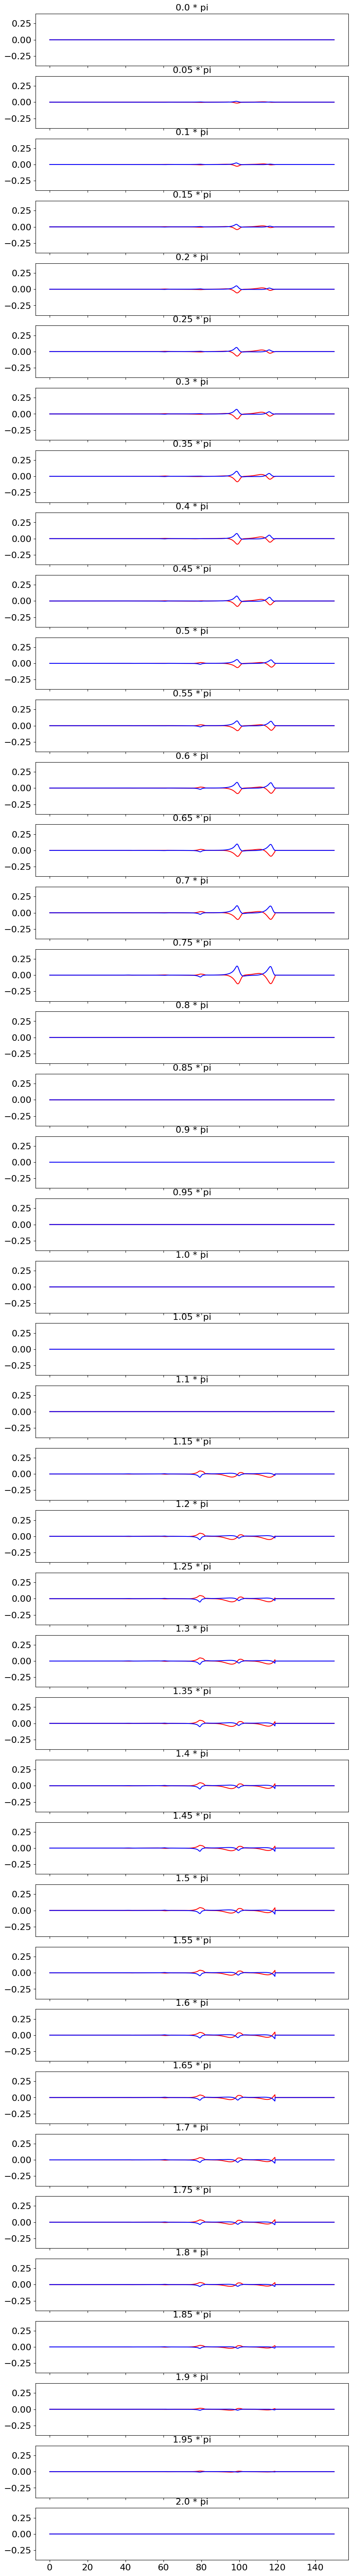

In [356]:
wc.params["exc_init"] = np.array([[init_peak[0]]])
wc.params["inh_init"] = np.array([[init_peak[1]]])

for i_w in range(len(results_peak["w2"])):

    if i_w not in [6]:
        continue

    w2 = results_peak['w2'][i_w]

    for i_shift in range(n_points):

        break
    
        period_shift = i_shift* 2.* np.pi / (n_points-1)
        index_shift = np.round(period * period_shift/ ( 2. * np.pi)/ dt).astype(int)
        target_shift = target_peak[:,:,index_shift:index_shift+np.round(1+duration/dt,1).astype(int)]

        wc_controlled = oc_wc.OcWc(wc, target=target_shift, w_p=1, w_2=w2, print_array=np.arange(0,1001,1001), precision_cost_interval=(int0,int1), control_interval=(c0, c1), control_matrix=control_mat, precision_matrix=prec_mat)
        results_peak["models"][i_w][i_shift] = wc_controlled

        wc_controlled.step = 1e-3
        wc_controlled.optimize(100)

        if i_shift in [0, n_points-1]:
            state = wc_controlled.get_xs()
            results_peak["control"][i_w][i_shift] = wc_controlled.control.copy()
            results_peak["state"][i_w][i_shift] = wc_controlled.get_xs().copy()
            results_peak["total_cost"][i_w][i_shift] = wc_controlled.cost_history.copy()

            wc_controlled.w_2 = 0.
            wc_controlled.simulate_forward()
            results_peak["precision_cost"][i_w][i_shift] = wc_controlled.compute_total_cost()
            results_peak["L2_cost_weighted"][i_w][i_shift] = ( results_peak["total_cost"][i_w][i_shift][-1] - results_peak["precision_cost"][i_w][i_shift]) 
            results_peak["L2_cost_unweighted"][i_w][i_shift] = results_peak["L2_cost_weighted"][i_w][i_shift] / w2
            wc_controlled.w_2 = w2
            continue

        wc_controlled.step = 1e-1
        wc_controlled.zero_step_encountered = False
        wc_controlled.optimize(200)

        wc_controlled.step = 1e1
        wc_controlled.zero_step_encountered = False
        wc_controlled.optimize(1000)
        
        results_peak["control"][i_w][i_shift] = wc_controlled.control.copy()
        results_peak["state"][i_w][i_shift] = wc_controlled.get_xs().copy()
        results_peak["total_cost"][i_w][i_shift] = wc_controlled.cost_history.copy()

        wc_controlled.w_2 = 0.
        wc_controlled.simulate_forward()
        results_peak["precision_cost"][i_w][i_shift] = wc_controlled.compute_total_cost()
        results_peak["L2_cost_weighted"][i_w][i_shift] = ( results_peak["total_cost"][i_w][i_shift][-1] - results_peak["precision_cost"][i_w][i_shift]) 
        results_peak["L2_cost_unweighted"][i_w][i_shift] = results_peak["L2_cost_weighted"][i_w][i_shift] / w2
        wc_controlled.w_2 = w2

    for i_shift in range(2, n_points-1):

        if i_shift not in []:
            continue

        period_shift = i_shift* 2.* np.pi / (n_points-1)
        index_shift = np.round(period * period_shift/ ( 2. * np.pi)/ dt).astype(int)
        target_shift = target_peak[:,:,index_shift:index_shift+np.round(1+duration/dt,1).astype(int)]

        wc_controlled = results_peak["models"][i_w][i_shift]
        
        #wc_controlled.control = results_peak["control"][i_w][i_shift-1].copy() * 1.1
        wc_controlled.control = results_peak["control"][i_w][8].copy() * 0.9
        wc_controlled.update_input()

        wc_controlled.step = 1e-3
        wc_controlled.zero_step_encountered = False
        wc_controlled.optimize(200)

        wc_controlled.step = 1e-1
        wc_controlled.zero_step_encountered = False
        wc_controlled.optimize(200)

        wc_controlled.step = 1e1
        wc_controlled.zero_step_encountered = False
        wc_controlled.optimize(1000)

        if wc_controlled.cost_history[-1] < results_peak["total_cost"][i_w][i_shift][-1]:
            print("-----------------------------------------------")
            print("0 found better solution")

            results_peak["control"][i_w][i_shift] = wc_controlled.control.copy()
            results_peak["state"][i_w][i_shift] = wc_controlled.get_xs().copy()
            results_peak["total_cost"][i_w][i_shift] = wc_controlled.cost_history.copy()

            wc_controlled.w_2 = 0.
            wc_controlled.simulate_forward()
            results_peak["precision_cost"][i_w][i_shift] = wc_controlled.compute_total_cost()
            results_peak["L2_cost_weighted"][i_w][i_shift] = ( results_peak["total_cost"][i_w][i_shift][-1] - results_peak["precision_cost"][i_w][i_shift]) 
            results_peak["L2_cost_unweighted"][i_w][i_shift] = results_peak["L2_cost_weighted"][i_w][i_shift] / w2
            wc_controlled.w_2 = w2

    for i_shift in range(n_points-3, 0, -1):

        if i_shift not in []:
            continue

        period_shift = i_shift* 2.* np.pi / (n_points-1)
        index_shift = np.round(period * period_shift/ ( 2. * np.pi)/ dt).astype(int)
        target_shift = target_peak[:,:,index_shift:index_shift+np.round(1+duration/dt,1).astype(int)]

        wc_controlled = results_peak["models"][i_w][i_shift]

        wc_controlled.control = results_peak["control"][i_w][i_shift+1].copy() * 1.1
        wc_controlled.update_input()
        wc_controlled.simulate_forward()

        wc_controlled.step = 1e-3
        wc_controlled.zero_step_encountered = False
        wc_controlled.optimize(200)

        wc_controlled.step = 1e-2
        wc_controlled.zero_step_encountered = False
        wc_controlled.optimize(200)

        wc_controlled.step = 1e-1
        wc_controlled.zero_step_encountered = False
        wc_controlled.optimize(200)

        wc_controlled.step = 1e1
        wc_controlled.zero_step_encountered = False
        wc_controlled.optimize(1000)

        if wc_controlled.cost_history[-1] < results_peak["total_cost"][i_w][i_shift][-1]:
            print("-----------------------------------------------")
            print("1 found better solution")

            results_peak["control"][i_w][i_shift] = wc_controlled.control.copy()
            results_peak["state"][i_w][i_shift] = wc_controlled.get_xs().copy()
            results_peak["total_cost"][i_w][i_shift] = wc_controlled.cost_history.copy()

            wc_controlled.w_2 = 0.
            wc_controlled.simulate_forward()
            results_peak["precision_cost"][i_w][i_shift] = wc_controlled.compute_total_cost()
            results_peak["L2_cost_weighted"][i_w][i_shift] = ( results_peak["total_cost"][i_w][i_shift][-1] - results_peak["precision_cost"][i_w][i_shift]) 
            results_peak["L2_cost_unweighted"][i_w][i_shift] = results_peak["L2_cost_weighted"][i_w][i_shift] / w2
            wc_controlled.w_2 = w2
            
    #plot(results_peak["control"][i_w], results_peak["filename"][i_w])

In [9]:
filehandler = open("results_peaks_w2.pickle","wb")
pickle.dump(results_peak,filehandler)
filehandler.close()

In [8]:
filehandler = open("results_peaks_w2.pickle","rb")
results_peak = pickle.load(filehandler)
filehandler.close()

In [94]:
wc = WCModel()
wc.params.sigma_ou = 0.

dt = 0.01
wc.params.dt = dt

duration = 300.
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
zero_control =np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]
input = zero_control.copy()

wc.params["duration"] = duration
x_init = 0.045135938287846025
y_init = 0.08586538415443892
wc.params["exc_init"] = np.array([[x_init]])
wc.params["inh_init"] = np.array([[y_init]])

wc.params["exc_ext"] = zero_input + 1.
wc.params["inh_ext"] = zero_input

wc.run()
de = 5.

peaks0 = scipy.signal.find_peaks(wc.exc[0,:])[0]
print(peaks0)
period = (peaks0[-1] - peaks0[-2])*dt
print("period = ", period)

i0, i1 = 0, 0
for i in range(len(peaks0)):
    if peaks0[i] > 100/dt:
        i0 = peaks0[i]
        i1 = peaks0[i+1]
        break

ind_range = range(i0, i1+1,1)
shift_ep = np.zeros((len(ind_range)))
shift_em = np.zeros((len(ind_range)))
shift_ip = np.zeros((len(ind_range)))
shift_im = np.zeros((len(ind_range)))

for i in range(len(ind_range)):
    t = ind_range[i]

    wc.params.exc_ext[0,t] += de
    wc.params.inh_ext[0,t] += -de
    wc.run()
    wc.params.exc_ext[0,t] -= de
    wc.params.inh_ext[0,t] -= -de

    peaks = scipy.signal.find_peaks(wc.exc[0,:])[0]
    shift_ep[i] = (peaks[-1] - peaks0[-1])*dt

    wc.params.exc_ext[0,t] += -de
    wc.params.inh_ext[0,t] += de
    wc.run()
    wc.params.exc_ext[0,t] -= -de
    wc.params.inh_ext[0,t] -= de

    peaks = scipy.signal.find_peaks(wc.exc[0,:])[0]
    shift_em[i] = (peaks[-1] - peaks0[-1])*dt

[ 1079  2916  4761  6606  8452 10297 12142 13988 15833 17678 19524 21369
 23214 25060 26905 28751]
period =  18.46


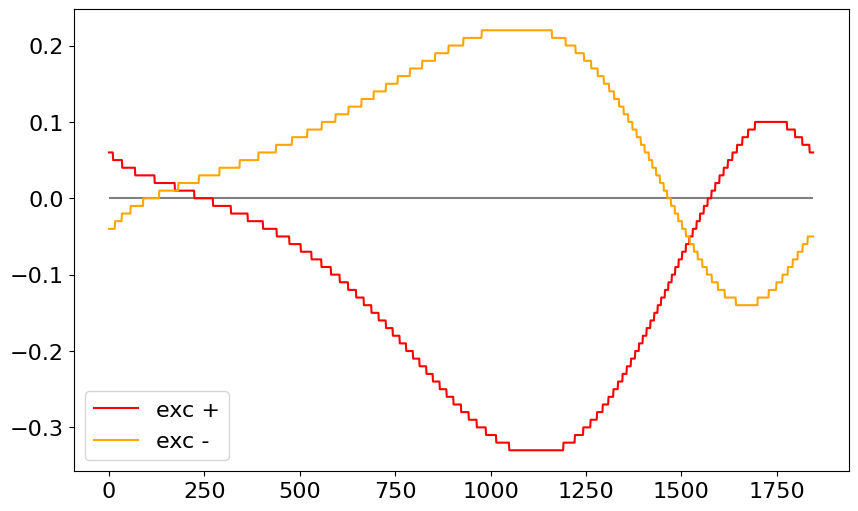

In [95]:
plt.plot(range(0,len(ind_range)), shift_ep, color="red", label="exc +")
plt.plot(range(0,len(ind_range)), shift_em, color="blue", label="exc -")
#plt.plot(range(0,len(ind_range)), shift_ip, color="blue", label="inh +")
#plt.plot(range(0,len(ind_range)), shift_im, color="purple", label="inh -")

plt.hlines(0., 0,len(ind_range), color="grey")
plt.legend(loc="lower left")
plt.show()